In [1]:
import os
import glob
from PIL import Image
import numpy as np
import pickle

dataset = "cifar-10-batches-py/data_batch_1"

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_dataset_dict = unpickle(dataset)

In [6]:
np_array_dataset = []

for flattened_arr in cifar_dataset_dict[b'data']:
    single_img_reshaped = np.transpose(np.reshape(flattened_arr,(3, 32,32)), (1,2,0))
    np_array_dataset.append(single_img_reshaped)

np_array_dataset = np.array(np_array_dataset)
random_indices = np.random.choice(np_array_dataset.shape[0], 2, replace=False)
np_array_dataset = np_array_dataset[random_indices]

In [113]:
from PIL import Image
from PIL.ImageOps import grayscale
from scipy.stats import pearsonr
from tqdm.auto import tqdm
from scipy import ndimage
from PIL import Image
from io import BytesIO

def apply_water_mark(img_arr, alpha=2.5):
    img_arr = np.array(grayscale(Image.fromarray(img_arr).resize((256, 256))))
    U, S, Vt = np.linalg.svd(img_arr, full_matrices=False)

    watermark_arr = np.random.normal(size=img_arr.shape)

    new_matrix = np.diag(S) + alpha * watermark_arr
    U_w, S_w, Vt_w = np.linalg.svd(new_matrix, full_matrices=False)
    watermarked_arr = U @ np.diag(S_w) @ Vt

    return img_arr, watermarked_arr, U_w, Vt_w, S, watermark_arr
    return img_arr.astype(np.uint8), watermarked_arr.astype(np.uint8), U_w, Vt_w, S, watermark_arr

def detect_watermark(a_w, U_w, Vt_w, S, original_w, alpha=2.5):
    U_bar, S_bar, Vt_bar = np.linalg.svd(a_w)
    w = ((U_w @ np.diag(S_bar) @ Vt_w) - np.diag(S)) / alpha

    return pearsonr(w.flatten(), original_w.flatten())

def rotate_image(image, angle, output_shape):
    width = output_shape[0]
    height = output_shape[1]
    rotated_image = ndimage.rotate(image, angle)
    center_x = rotated_image.shape[0] // 2
    center_y = rotated_image.shape[1] // 2
    rotated_crop = rotated_image[center_x - width // 2: center_x + width // 2, center_y - height // 2: center_y + height // 2]
    return rotated_crop

def compress_image(image, quality):
    # image is a numpy array
    # quality is an integer
    # return compressed image

    # Create a BytesIO buffer to temporarily store the image
    img_buffer = BytesIO()

    # Convert the numpy array to an image and save it to the buffer with the specified quality
    img = Image.fromarray(image.astype("uint8"))
    img.save(img_buffer, format='JPEG', quality=quality)

    # Reset the buffer's position to the beginning
    img_buffer.seek(0)

    # Read the compressed image data from the buffer and convert it to a numpy array
    img_array = np.array(Image.open(img_buffer))

    return img_array

output_dict = {}
compression_levels = [25, 50, 75]
rotation_degrees = [90, 180, 270]

for i, image_arr in tqdm(enumerate(np_array_dataset), total=len(np_array_dataset)):
    clean_img, watermarked_img, U_w, Vt_w, S, original_w = apply_water_mark(image_arr)
    watermarked_compressed25_img = compress_image(watermarked_img, 25)
    watermarked_compressed50_img = compress_image(watermarked_img, 50)
    watermarked_compressed75_img = compress_image(watermarked_img, 75)
    watermarked_rotated90_img = rotate_image(watermarked_img, 90, watermarked_img.shape)
    watermarked_rotated180_img = rotate_image(watermarked_img, 180, watermarked_img.shape)
    watermarked_rotated270_img = rotate_image(watermarked_img, 270, watermarked_img.shape)
    
    clean_detection_score = detect_watermark(clean_img, U_w, Vt_w, S, original_w)
    watermarked_detection_score = detect_watermark(watermarked_img, U_w, Vt_w, S, original_w)
    watermarked_compressed_25_detection_score = detect_watermark(watermarked_compressed25_img, U_w, Vt_w, S, original_w)
    watermarked_compressed_50_detection_score = detect_watermark(watermarked_compressed50_img, U_w, Vt_w, S, original_w)
    watermarked_compressed_75_detection_score = detect_watermark(watermarked_compressed75_img, U_w, Vt_w, S, original_w)
    watermarked_rotated90_detection_score = detect_watermark(watermarked_rotated90_img, U_w, Vt_w, S, original_w)
    watermarked_rotated180_detection_score = detect_watermark(watermarked_rotated180_img, U_w, Vt_w, S, original_w)
    watermarked_rotated270_detection_score = detect_watermark(watermarked_rotated270_img, U_w, Vt_w, S, original_w)
    output_dict[i] = {
        "original_image": clean_img,
        "watermarked_image": watermarked_img,
        "U_w": U_w,
        "Vt_w": Vt_w,
        "S": S,
        "original_w": original_w,
        "watermarked_image_detection_score": watermarked_detection_score,
        "watermarked_compressed_25_detection_score": watermarked_compressed_25_detection_score,
        "watermarked_compressed_50_detection_score": watermarked_compressed_50_detection_score,
        "watermarked_compressed_75_detection_score": watermarked_compressed_75_detection_score,
        "watermarked_rotated90_detection_score": watermarked_rotated90_detection_score,
        "watermarked_rotated180_detection_score": watermarked_rotated180_detection_score,
        "watermarked_rotated270_detection_score": watermarked_rotated270_detection_score,
        "clean_image_detection_score": clean_detection_score
    }

100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s]


In [79]:
output_dict[0]["watermarked_image_detection_score"], output_dict[0]["clean_image_detection_score"]

(PearsonRResult(statistic=1.0, pvalue=0.0),
 PearsonRResult(statistic=0.6367837755996526, pvalue=0.0))

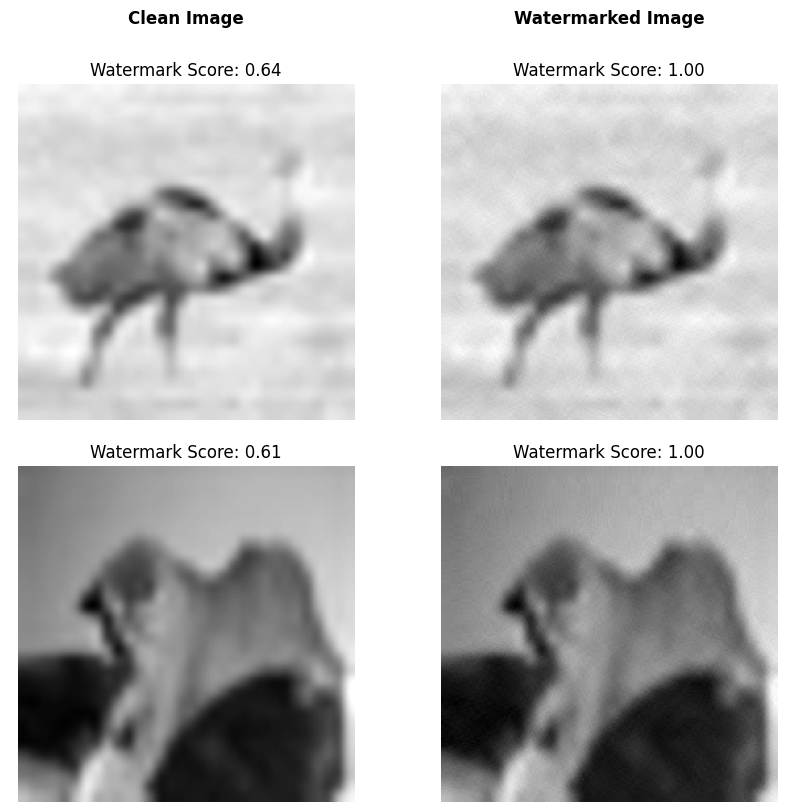

In [112]:
import matplotlib.pyplot as plt

fig, ((title_ax1, title_ax2), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={"height_ratios":[0.02,1,1]})

title_ax1.axis("off")
title_ax2.axis("off")
title_ax1.set_title("Clean Image", fontweight="bold")
title_ax2.set_title("Watermarked Image", fontweight="bold")
    
ax1.imshow(output_dict[0]["original_image"], cmap='gray')
ax1.set_title(f"Watermark Score: {output_dict[0]['clean_image_detection_score'].statistic:.2f}")
ax1.axis('off')
ax2.imshow(output_dict[0]["watermarked_image"], cmap='gray')
ax2.set_title(f"Watermark Score: {output_dict[0]['watermarked_image_detection_score'].statistic:.2f}")
ax2.axis('off')

ax3.imshow(output_dict[1]["original_image"], cmap='gray')
ax3.set_title(f"Watermark Score: {output_dict[1]['clean_image_detection_score'].statistic:.2f}")
ax3.axis('off')
ax4.imshow(output_dict[1]["watermarked_image"], cmap='gray')
ax4.set_title(f"Watermark Score: {output_dict[1]['watermarked_image_detection_score'].statistic:.2f}")
ax4.axis('off')
plt.savefig("plots/watermark_example.png")